In [ ]:
from google.colab import drive
import os
if not os.path.exists('/content/drive/MyDrive'):
    drive.mount('/content/drive')
else:
    print("Google Drive already mounted")
DATA_DIR = "/content/drive/MyDrive/tokenized_subset"
BIN_DIR  = os.path.join(DATA_DIR, "bin")
os.makedirs(BIN_DIR, exist_ok=True)

TRAIN_TXT = os.path.join(DATA_DIR, "train.txt")
VAL_TXT   = os.path.join(DATA_DIR, "val.txt")
TEST_TXT  = os.path.join(DATA_DIR, "test.txt")


Google Drive already mounted


In [ ]:
files = {
    "TRAIN_TXT": TRAIN_TXT,
    "VAL_TXT": VAL_TXT,
    "TEST_TXT": TEST_TXT
}

for name, path in files.items():
    if os.path.exists(path):
        print(f"{name} exists at: {path}")
    else:
        print(f"{name} does NOT exist at: {path}")


TRAIN_TXT exists at: /content/drive/MyDrive/tokenized_subset/train.txt
VAL_TXT exists at: /content/drive/MyDrive/tokenized_subset/val.txt
TEST_TXT exists at: /content/drive/MyDrive/tokenized_subset/test.txt


In [ ]:
import os
import numpy as np
import json

def encode_file(txt_path, bin_path, vocab_path):
    if os.path.exists(bin_path):
        print(f"{bin_path} already exists, skipping.")
        return


    with open(vocab_path, "r") as f:
        vocab = json.load(f)

    print(f"Encoding {txt_path} -> {bin_path}")
    tokens = []
    with open(txt_path, "r") as f:
        for line in f:
            ids = [int(tok) for tok in line.strip().split()]
            tokens.extend(ids)

    np_tokens = np.array(tokens, dtype=np.uint32)
    np_tokens.tofile(bin_path)
    print(f"Saved {bin_path}, total tokens: {len(tokens)}")



VOCAB_PATH = os.path.join(DATA_DIR, "vocab.json")
TRAIN_BIN = os.path.join(BIN_DIR, "train.bin")
VAL_BIN   = os.path.join(BIN_DIR, "val.bin")
TEST_BIN  = os.path.join(BIN_DIR, "test.bin")

encode_file(TRAIN_TXT, TRAIN_BIN, VOCAB_PATH)
encode_file(VAL_TXT, VAL_BIN, VOCAB_PATH)
encode_file(TEST_TXT, TEST_BIN, VOCAB_PATH)


/content/drive/MyDrive/tokenized_subset/bin/train.bin already exists, skipping.
/content/drive/MyDrive/tokenized_subset/bin/val.bin already exists, skipping.
/content/drive/MyDrive/tokenized_subset/bin/test.bin already exists, skipping.


In [ ]:

VOCAB_JSON = os.path.join(DATA_DIR, "vocab.json")
with open(VOCAB_JSON, "r") as f:
    vocab = json.load(f)
vocab_size = len(vocab)

print("Vocab size:", vocab_size)

Vocab size: 1734


In [ ]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cuda


In [ ]:


TRAIN_BIN = "/content/drive/MyDrive/tokenized_subset/bin/train.bin"
total_tokens = len(np.memmap(TRAIN_BIN, dtype=np.uint32, mode='r'))
vocab_size = int(np.memmap(TRAIN_BIN, dtype=np.uint32, mode="r").max()) + 1
batch_size = 8
block_size = 256


steps_per_epoch = total_tokens // (batch_size * block_size)

print("Total tokens in training set:", total_tokens)
print("Steps needed for 1 epoch:", steps_per_epoch)


Total tokens in training set: 140459152
Steps needed for 1 epoch: 68583


In [ ]:
class BinDataset:
    def __init__(self, path, block_size):
        self.data = np.memmap(path, dtype=np.uint32, mode='r')
        self.block_size = block_size

    def get_batch(self, batch_size, device):
        ix = torch.randint(len(self.data) - self.block_size - 1, (batch_size,))
        x = torch.stack([
            torch.from_numpy(self.data[i:i+self.block_size].astype(np.int64))
            for i in ix
        ])
        y = torch.stack([
            torch.from_numpy(self.data[i+1:i+self.block_size+1].astype(np.int64))
            for i in ix
        ])
        return x.to(device), y.to(device)


In [ ]:
block_size = 256

train_data = BinDataset(TRAIN_BIN, block_size)
val_data   = BinDataset(VAL_BIN, block_size)
total_train_tokens = len(train_data.data)
print(total_train_tokens)

140459152


In [ ]:
class CausalSelfAttention(nn.Module):
    def __init__(self, n_embd, n_head, block_size):
        super().__init__()
        self.n_head = n_head
        self.key   = nn.Linear(n_embd, n_embd)
        self.query = nn.Linear(n_embd, n_embd)
        self.value = nn.Linear(n_embd, n_embd)
        self.proj  = nn.Linear(n_embd, n_embd)
        self.register_buffer("mask", torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.size()
        k = self.key(x).view(B, T, self.n_head, C//self.n_head).transpose(1,2)
        q = self.query(x).view(B, T, self.n_head, C//self.n_head).transpose(1,2)
        v = self.value(x).view(B, T, self.n_head, C//self.n_head).transpose(1,2)

        att = (q @ k.transpose(-2, -1)) / math.sqrt(k.size(-1))
        att = att.masked_fill(self.mask[:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)

        y = att @ v
        y = y.transpose(1,2).contiguous().view(B, T, C)
        return self.proj(y)


class Block(nn.Module):
    def __init__(self, n_embd, n_head, block_size):
        super().__init__()
        self.ln1 = nn.LayerNorm(n_embd)
        self.attn = CausalSelfAttention(n_embd, n_head, block_size)
        self.ln2 = nn.LayerNorm(n_embd)
        self.mlp = nn.Sequential(
            nn.Linear(n_embd, 4*n_embd),
            nn.GELU(),
            nn.Linear(4*n_embd, n_embd)
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x


class TransformerLM(nn.Module):
    def __init__(self, vocab_size, n_layer, n_head, n_embd, block_size):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, n_embd)
        self.pos_emb = nn.Parameter(torch.zeros(1, block_size, n_embd))
        self.blocks = nn.ModuleList([
            Block(n_embd, n_head, block_size) for _ in range(n_layer)
        ])
        self.ln_f = nn.LayerNorm(n_embd)
        self.head = nn.Linear(n_embd, vocab_size)

    def forward(self, x, targets=None):
        B, T = x.size()
        x = self.tok_emb(x) + self.pos_emb[:, :T]
        for blk in self.blocks:
            x = blk(x)
        x = self.ln_f(x)
        logits = self.head(x)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),
                targets.view(-1)
            )
        return logits, loss


In [ ]:
def count_params(model):
    return sum(p.numel() for p in model.parameters()) / 1e6


In [ ]:
def train_one_model(cfg, train_data, val_data):
    model = TransformerLM(**cfg).to(device)

    batch_size = 8
    tokens_per_step = batch_size * block_size
    EPOCH_STEPS = total_train_tokens // tokens_per_step

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=3e-4,
        betas=(0.9, 0.95),
        weight_decay=0.1
    )

    warmup_steps = int(0.05 * EPOCH_STEPS)
    min_lr = 3e-5

    def get_lr(step):
        if step < warmup_steps:
            return 3e-4 * step / warmup_steps
        progress = (step - warmup_steps) / (EPOCH_STEPS - warmup_steps)
        return max(
            min_lr,
            3e-4 * 0.5 * (1.0 + math.cos(math.pi * progress))
        )

    loss_ema = None
    ema_beta = 0.95
    loss_curve = []

    torch.cuda.reset_peak_memory_stats()
    start_time = time.time()

    model.train()
    for step in range(EPOCH_STEPS):
        lr = get_lr(step)
        for pg in optimizer.param_groups:
            pg["lr"] = lr

        xb, yb = train_data.get_batch(batch_size, device)
        _, loss = model(xb, yb)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        loss_val = loss.item()
        loss_ema = loss_val if loss_ema is None else (
            ema_beta * loss_ema + (1 - ema_beta) * loss_val
        )
        loss_curve.append(loss_ema)

        if step % 5000 == 0:
            print(f"step {step} | lr {lr:.2e} | loss {loss_ema:.4f}")


    torch.manual_seed(1337)
    model.eval()
    val_losses = []
    with torch.no_grad():
        for _ in range(500):
            xb, yb = val_data.get_batch(batch_size, device)
            _, loss = model(xb, yb)
            val_losses.append(loss.item())

    val_loss = sum(val_losses) / len(val_losses)
    params = count_params(model)

    elapsed_min = (time.time() - start_time) / 60
    peak_mem = torch.cuda.max_memory_allocated() / 1024**2

    del model
    torch.cuda.empty_cache()

    return {
        "params_M": params,
        "val_loss": val_loss,
        "loss_curve": loss_curve,
        "time_min": elapsed_min,
        "peak_mem_MB": peak_mem
    }


In [ ]:
vocab_size = 1734
block_size = 256

configs = {

    "Tiny": dict(
        vocab_size=vocab_size,
        n_layer=6,
        n_head=6,
        n_embd=192,
        block_size=block_size
    ),


    "Small": dict(
        vocab_size=vocab_size,
        n_layer=8,
        n_head=8,
        n_embd=256,
        block_size=block_size
    ),

    "Medium": dict(
        vocab_size=vocab_size,
        n_layer=12,
        n_head=12,
        n_embd=384,
        block_size=block_size
    ),
    "Large": dict(
        vocab_size=vocab_size,
        n_layer=16,
        n_head=16,
        n_embd=512,
        block_size=block_size
    ),


    "XL": dict(
        vocab_size=vocab_size,
        n_layer=20,
        n_head=20,
        n_embd=640,
        block_size=block_size
    ),
}


In [ ]:
for name, cfg in configs.items():
    model = TransformerLM(**cfg)
    params = count_params(model)
    print(f"{name}: {params:.2f}M parameters")
    del model


Tiny: 3.39M parameters
Small: 7.27M parameters
Medium: 22.73M parameters
Large: 52.35M parameters
XL: 100.86M parameters


In [ ]:
results = {}

for name, cfg in configs.items():
    print(f"\n===== Training {name} =====")

    stats = train_one_model(cfg, train_data, val_data)
    results[name] = stats

    print(
        f"{name} | "
        f"Params: {stats['params_M']:.2f}M | "
        f"Val Loss: {stats['val_loss']:.4f} | "
        f"Time: {stats['time_min']:.2f} min | "
        f"Peak GPU: {stats['peak_mem_MB']:.1f} MB"
    )



===== Training Tiny =====
step 0 | lr 0.00e+00 | loss 7.6401
step 5000 | lr 3.00e-04 | loss 1.8862
step 10000 | lr 2.93e-04 | loss 1.4662
step 15000 | lr 2.77e-04 | loss 1.3827
step 20000 | lr 2.55e-04 | loss 1.3489
step 25000 | lr 2.26e-04 | loss 1.2873
step 30000 | lr 1.93e-04 | loss 1.2749
step 35000 | lr 1.57e-04 | loss 1.2504
step 40000 | lr 1.21e-04 | loss 1.1548
step 45000 | lr 8.70e-05 | loss 1.1703
step 50000 | lr 5.63e-05 | loss 1.1661
step 55000 | lr 3.10e-05 | loss 1.0875
step 60000 | lr 3.00e-05 | loss 1.2141
step 65000 | lr 3.00e-05 | loss 1.1599
Tiny | Params: 3.39M | Val Loss: 2.3586 | Time: 19.79 min | Peak GPU: 470.0 MB

===== Training Small =====
step 0 | lr 0.00e+00 | loss 7.7585
step 5000 | lr 3.00e-04 | loss 1.7926
step 10000 | lr 2.93e-04 | loss 1.3058
step 15000 | lr 2.77e-04 | loss 1.2833
step 20000 | lr 2.55e-04 | loss 1.1893
step 25000 | lr 2.26e-04 | loss 1.2120
step 30000 | lr 1.93e-04 | loss 1.2307
step 35000 | lr 1.57e-04 | loss 1.2212
step 40000 | lr 1.

In [ ]:
import json

with open(f"{DATA_DIR}/transformer_results.json", "w") as f:
    json.dump(results, f, indent=4)

print("✅ Transformer results saved to Drive")

✅ Transformer results saved to Drive


Fitted parameters:
a     = 47.3940
alpha = 0.3661
c     = 2.1657


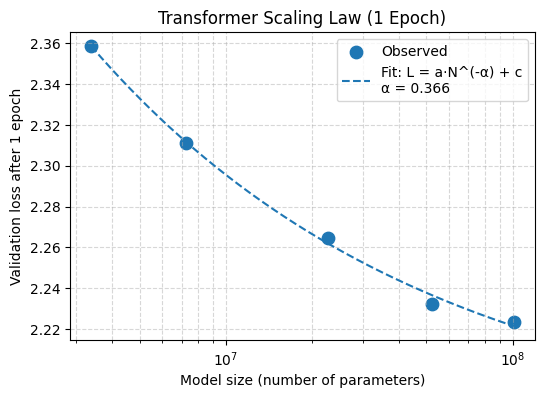

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

model_names = list(results.keys())
N = np.array([results[k]["params_M"] * 1e6 for k in model_names])
L = np.array([results[k]["val_loss"] for k in model_names])

def scaling_law(N, a, alpha, c):
    return a * N**(-alpha) + c
p0 = [1.0, 0.05, min(L)]


params, _ = curve_fit(scaling_law, N, L, p0=p0, maxfev=10000)
a_fit, alpha_fit, c_fit = params

print(f"Fitted parameters:")
print(f"a     = {a_fit:.4f}")
print(f"alpha = {alpha_fit:.4f}")
print(f"c     = {c_fit:.4f}")


plt.figure(figsize=(6,4))
plt.scatter(N, L, s=80, label="Observed")

N_fit = np.logspace(np.log10(N.min()), np.log10(N.max()), 300)
L_fit = scaling_law(N_fit, a_fit, alpha_fit, c_fit)

plt.plot(
    N_fit, L_fit, "--",
    label=f"Fit: L = a·N^(-α) + c\nα = {alpha_fit:.3f}"
)

plt.xscale("log")
plt.xlabel("Model size (number of parameters)")
plt.ylabel("Validation loss after 1 epoch")
plt.title("Transformer Scaling Law (1 Epoch)")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.show()


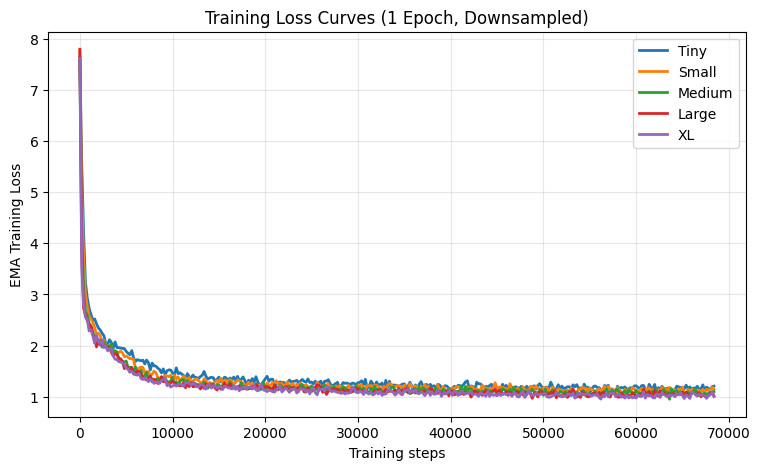

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(9, 5))

stride = 200

for name, stats in results.items():
    loss = np.array(stats["loss_curve"])
    steps = np.arange(len(loss))
    plt.plot(steps[::stride], loss[::stride], label=name, linewidth=2)

plt.xlabel("Training steps")
plt.ylabel("EMA Training Loss")
plt.title("Training Loss Curves (1 Epoch, Downsampled)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
for name, stats in results.items():
    print(
        f"{name:6s} | "
        f"Time: {stats['time_min']:.2f} min | "
        f"Peak GPU: {stats['peak_mem_MB']:.1f} MB"
    )


Tiny   | Time: 19.79 min | Peak GPU: 470.0 MB
Small  | Time: 25.73 min | Peak GPU: 694.6 MB
Medium | Time: 41.72 min | Peak GPU: 1435.1 MB
Large  | Time: 82.11 min | Peak GPU: 2541.5 MB
XL     | Time: 133.99 min | Peak GPU: 4189.9 MB


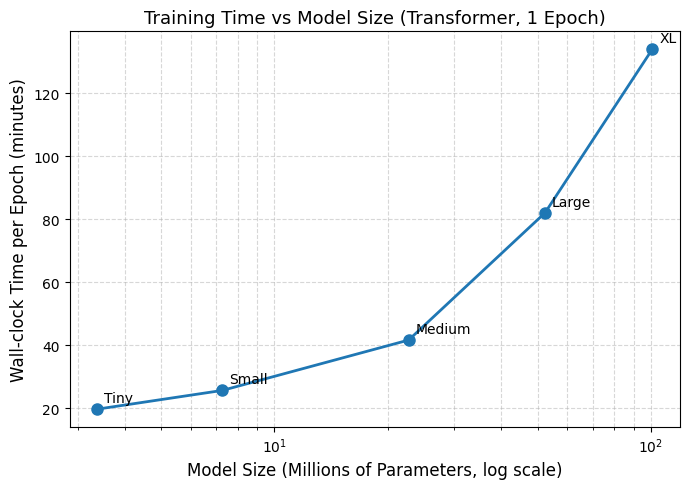

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

names  = list(results.keys())
params = np.array([results[n]["params_M"] for n in names])
times  = np.array([results[n]["time_min"] for n in names])

plt.figure(figsize=(7,5))
plt.plot(
    params,
    times,
    marker="o",
    linewidth=2,
    markersize=8
)

plt.xscale("log")
plt.xlabel("Model Size (Millions of Parameters, log scale)", fontsize=12)
plt.ylabel("Wall-clock Time per Epoch (minutes)", fontsize=12)
plt.title("Training Time vs Model Size (Transformer, 1 Epoch)", fontsize=13)
for i, name in enumerate(names):
    plt.annotate(
        name,
        (params[i], times[i]),
        textcoords="offset points",
        xytext=(5, 5),
        fontsize=10
    )

plt.grid(True, which="both", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


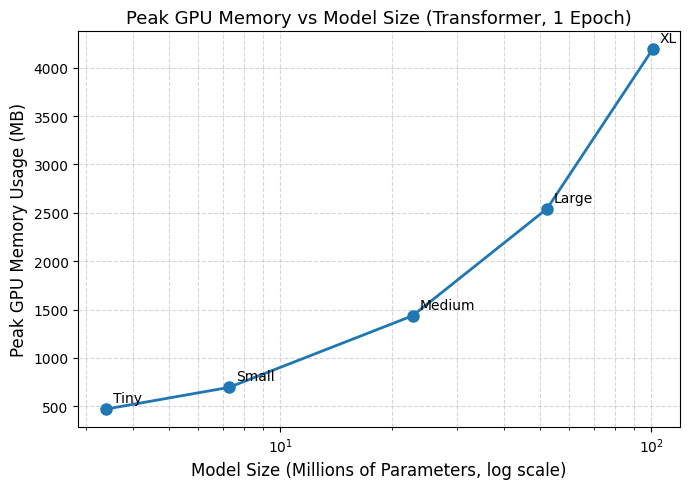

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

names  = list(results.keys())
params = np.array([results[n]["params_M"] for n in names])
mem    = np.array([results[n]["peak_mem_MB"] for n in names])

plt.figure(figsize=(7,5))


plt.plot(
    params,
    mem,
    marker="o",
    linewidth=2,
    markersize=8
)


plt.xscale("log")


plt.xlabel("Model Size (Millions of Parameters, log scale)", fontsize=12)
plt.ylabel("Peak GPU Memory Usage (MB)", fontsize=12)
plt.title("Peak GPU Memory vs Model Size (Transformer, 1 Epoch)", fontsize=13)


for i, name in enumerate(names):
    plt.annotate(
        name,
        (params[i], mem[i]),
        textcoords="offset points",
        xytext=(5, 5),
        fontsize=10
    )


plt.grid(True, which="both", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()
